In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import itertools
import json
from deap import algorithms, base, creator, tools

## Loading data

In [2]:
return_type = "naive"


if return_type == "naive":
    returns = pd.read_csv("../data/predicted_returns_naive.csv",index_col="Date")
elif return_type == "prophet":
    returns = pd.read_csv("../data/predicted_returns_prophet.csv",index_col="Date")


ibov_return = pd.read_csv("../data/weekly_ibov.csv",index_col="Date")
volatilities = pd.read_csv("../data/volatility_garch_1_1_7.csv",index_col="Date")
selic = pd.read_csv("../data/weekly_selic.csv",index_col="Date")


returns.index = pd.to_datetime(returns.index)
ibov_return.index = pd.to_datetime(ibov_return.index)
volatilities.index = pd.to_datetime(volatilities.index)
selic.index = pd.to_datetime(selic.index)

assets = returns.columns

The function below is responsible for getting the portifolio return based on each asset return and the weights given for each asset.

*Parameters:*
 - weights: array with each element being the weight assinged for each asset.
 - asset_returns: array with each element being the asset return. 


In [3]:
def portifolio_return(weights, asset_returns):
        
    port_ret = np.dot(weights,asset_returns)
    
    return port_ret

The function below is responsible for getting the portifolio volatility based on each asset volatility and the weights given for each asset.

*Parameters:*
 - weights: array with each element being the weight assinged for each asset.
 - asset_volatilities: array with each element being the asset volatility predicted by a GARCH Model. 

*Disclaimer:*
 - In the current version, volatilities are being estimated through historical variance and covariance

In [4]:

def portifolio_volatility(weights,asset_volatilities,cov_matrix):
    
    weights_np = np.array(weights)
    
    port_vol = np.sqrt(np.dot(weights_np.T,np.dot(cov_matrix,weights_np)))
    
    return port_vol

In [5]:
weights = np.ones(len(returns.iloc[0,:]))/len(returns.iloc[0,:])


portifolio_return(asset_returns=returns.iloc[0,:],
                  weights=weights)



0.022449228310393612

## GA Optimization

Por enquanto eu apenas estou maximizando retorno, sem olhar a volatilidade

In [6]:
# The objective funcion is just the return 
def objective_function(individual):

    ret = portifolio_return(individual,asset_returns)
        
    return (ret),
    

In [7]:
def feasible(individual):
    cond1 = 1-sum(individual)>0 
    cond2 = sum(individual)-1<10e-7
    
    all_positive = True
    for gene in individual:
        if gene < 0:
            all_positive = False
            
    #port_vol = portifolio_volatility(individual,asset_volatilities)
    #cond_vol = port_vol <= 0.15
    return cond1 and cond2 and all_positive  #and cond_vol

In [8]:
def distance(individual):
    
    return (abs(sum(individual)-1)),

### GA setup

In [9]:
creator.create('FitnessMax',base.Fitness,weights=(1.0,)) 
creator.create('Individual',list,fitness=creator.FitnessMax) 

In [10]:
qtd_assets = len(returns.columns)

In [11]:
toolbox = base.Toolbox()

toolbox.register("attr_weight", random.uniform, 0, 1/20)

toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_weight, n=qtd_assets)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)  

In [12]:
toolbox.register("evaluate", objective_function)     
toolbox.decorate("evaluate", tools.DeltaPenalty(feasible, 0, distance))

In [13]:
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register('mutate', tools.mutGaussian, mu=0, sigma=1, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

In [14]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register('avg',np.mean)
stats.register('std',np.std)
stats.register('max',np.max)
stats.register('min',np.min)

In [15]:
train_returns = returns[returns.index.year < 2020]
test_returns =  returns[returns.index.year >= 2020]

train_volatilities = volatilities[volatilities.index.year < 2020]
test_volatilities = volatilities[volatilities.index.year >= 2020]

## Hyperparameter Search on training dataset

In [16]:
hyperparameters = {"population":[50,100],
                   "cxpb":[0.3,0.5],
                    "mutpb":[0.05,0.1],
                    "ngen":[20,50]}

keys, values = zip(*hyperparameters.items())
hyperparameters_permutations = [dict(zip(keys, v)) for v in itertools.product(*values)]

print("Number of models to do compared = %d"%len(hyperparameters_permutations))

Number of models to do compared = 16


In [17]:
best_cummulative_return = 0
best_hyperparametrs = {}
best_weights = []
best_cummulative_returns = pd.DataFrame()

window = 14

global_list_weights = []


for parameters in hyperparameters_permutations:
    optimal_returns = {}
    best_individuals = {}
    
    hof = tools.HallOfFame(1)
    pop = toolbox.population(n=parameters["population"]) 
    cxpb = parameters["cxpb"]
    mutpb = parameters["mutpb"]
    ngen = parameters["ngen"]
    
    list_weights = []
    
    for week in range(window,len(train_returns)):
        
        # Idx is the current week
        idx = train_returns.index[week]
        
        # Individual asset return for that week
        asset_returns = train_returns.loc[idx,:]
        #Individual Asset Volatility for that week
        asset_volatilities = train_volatilities.loc[idx,:]
        # Selic from that week
        selic_week= selic.loc[idx]
        
        # Return covariance matrix considering the last window weeks
        cov_matrix = train_returns.iloc[week-window:week,:].cov()

        pop,log = algorithms.eaSimple(population=pop, toolbox=toolbox, cxpb=cxpb, mutpb=mutpb,
                                ngen=ngen, stats=stats, halloffame=hof,verbose=False)
        

        best_individuals[idx] = hof[0]
        optimal_returns[idx] = objective_function(hof[0])
        
    global_list_weights.append(best_individuals)
    optimal_returns = pd.DataFrame(index=optimal_returns.keys(),data=optimal_returns.values())
    portifolio_cummulative_return = optimal_returns.cumsum()
    
    
    
    if portifolio_cummulative_return.values[-1][0] > best_cummulative_return:
        best_hyperparametrs = parameters
        best_weights = best_individuals
        best_cummulative_returns = portifolio_cummulative_return

    print("Optimization Finished")
    print(parameters)
    
print("Best Hyperparameters are:")
print(best_hyperparametrs)


Optimization Finished
{'population': 50, 'cxpb': 0.3, 'mutpb': 0.05, 'ngen': 20}
Optimization Finished
{'population': 50, 'cxpb': 0.3, 'mutpb': 0.05, 'ngen': 50}
Optimization Finished
{'population': 50, 'cxpb': 0.3, 'mutpb': 0.1, 'ngen': 20}
Optimization Finished
{'population': 50, 'cxpb': 0.3, 'mutpb': 0.1, 'ngen': 50}
Optimization Finished
{'population': 50, 'cxpb': 0.5, 'mutpb': 0.05, 'ngen': 20}
Optimization Finished
{'population': 50, 'cxpb': 0.5, 'mutpb': 0.05, 'ngen': 50}
Optimization Finished
{'population': 50, 'cxpb': 0.5, 'mutpb': 0.1, 'ngen': 20}
Optimization Finished
{'population': 50, 'cxpb': 0.5, 'mutpb': 0.1, 'ngen': 50}
Optimization Finished
{'population': 100, 'cxpb': 0.3, 'mutpb': 0.05, 'ngen': 20}
Optimization Finished
{'population': 100, 'cxpb': 0.3, 'mutpb': 0.05, 'ngen': 50}
Optimization Finished
{'population': 100, 'cxpb': 0.3, 'mutpb': 0.1, 'ngen': 20}
Optimization Finished
{'population': 100, 'cxpb': 0.3, 'mutpb': 0.1, 'ngen': 50}
Optimization Finished
{'popula

### Saving the best hyperparameters

In [18]:
with open("../output/hyperparameters/hyperparameters_justreturn_ret_"+return_type+".json", "w") as outfile:
    json.dump(best_hyperparametrs, outfile)

### Saving the best weights on training data

In [19]:
best_weights = pd.DataFrame(index=best_weights.keys(),data=best_weights.values(),columns=assets)
best_weights.to_csv("../output/weights/weights_train_justreturn_ret_"+return_type+".csv")

### Saving the best cummulative returns on training data

In [20]:
best_cummulative_returns.rename(columns={0:"Return"},inplace=True)
best_cummulative_returns.to_csv("../output/cummulative_returns/cummulative_returns_train_justreturn_ret_"+return_type+".csv")

## Cummulative return comparison plot on training data

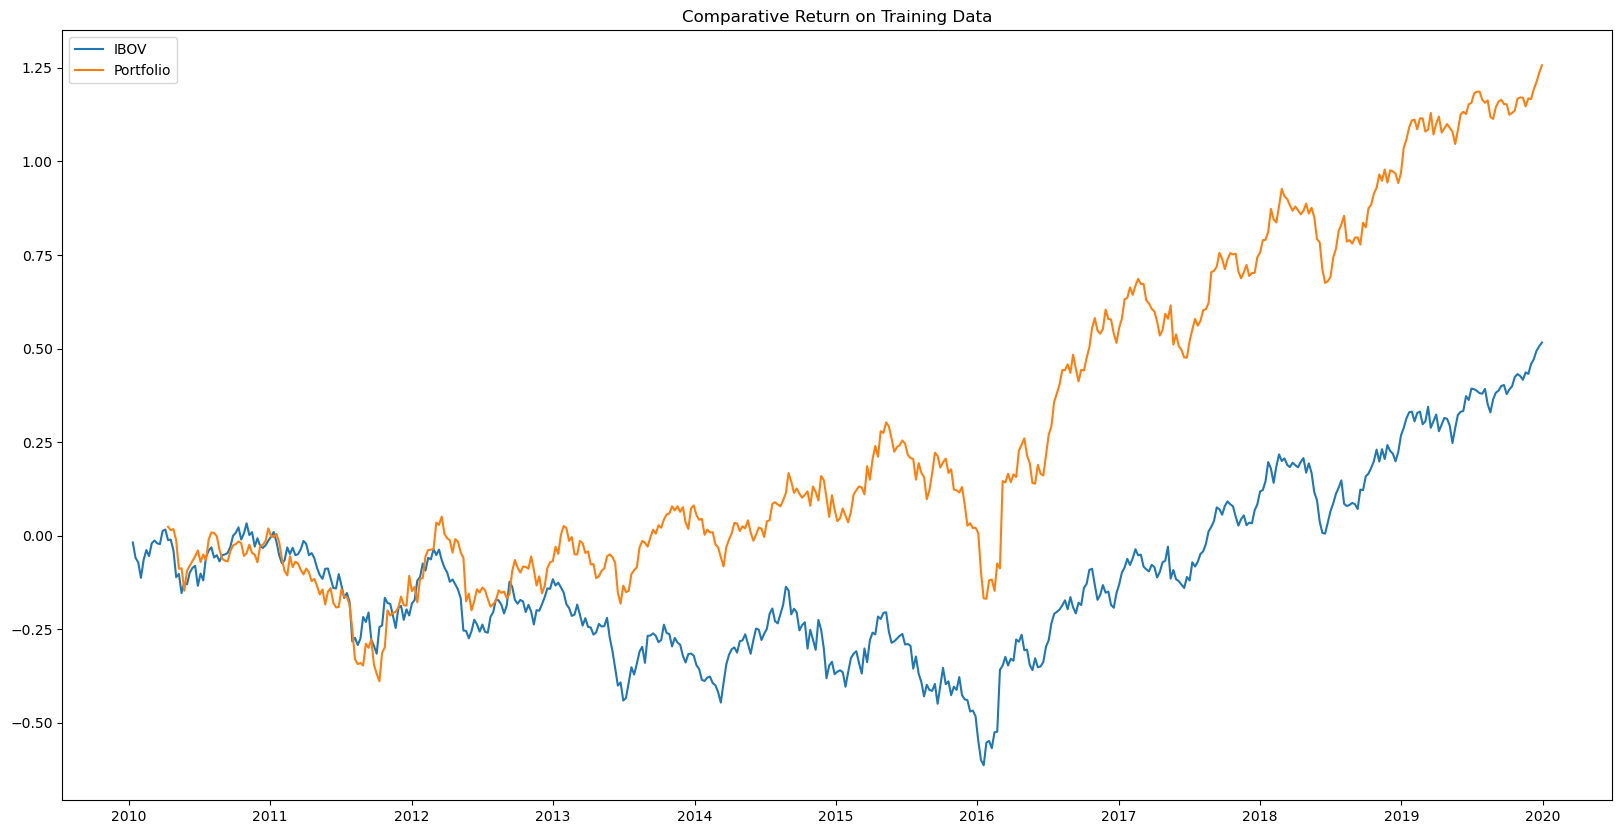

In [21]:
ibov_cummulative_return = ibov_return.cumsum()

train_ibov = ibov_cummulative_return[ibov_cummulative_return.index.year<2020]
test_ibov = ibov_cummulative_return[ibov_cummulative_return.index.year>=2020]

plt.figure(figsize=(20,10))
plt.plot(train_ibov,label="IBOV")
plt.plot(best_cummulative_returns,label="Portfolio")
plt.title("Comparative Return on Training Data")
plt.legend()
plt.savefig("../output/images/comparative_return_train_justreturn_ret_"+return_type+".png")
plt.show()

## Best Hyperparameters result on test data

In [22]:
best_individuals = {}
optimal_returns = {}

hof = tools.HallOfFame(1)
pop = toolbox.population(n=best_hyperparametrs["population"]) 

cxpb = best_hyperparametrs["cxpb"]
mutpb = best_hyperparametrs["mutpb"]
ngen = best_hyperparametrs["ngen"]

for week in range(window,len(test_returns)):
        
        idx = test_returns.index[week]
        
        asset_returns = test_returns.loc[idx,:]
        asset_volatilities = test_volatilities.loc[idx,:]
        selic_week= selic.loc[idx]
        
        cov_matrix = test_returns.iloc[week-window:week,:].cov()

        pop,log = algorithms.eaSimple(population=pop, toolbox=toolbox, cxpb=cxpb, mutpb=mutpb,
                                ngen=ngen, stats=stats, halloffame=hof,verbose=False)
        

        best_individuals[idx] = hof[0]
        optimal_returns[idx] = objective_function(hof[0])
        
optimal_returns = pd.DataFrame(index=optimal_returns.keys(),data=optimal_returns.values())
optimal_returns.rename(columns={0:"Return"},inplace=True)    

portifolio_cummulative_return = optimal_returns.cumsum()
    

### Saving the best cummulative returns on test data

In [23]:
portifolio_cummulative_return.to_csv("../output/cummulative_returns/cummulative_returns_test_justreturn_ret_"+return_type+".csv")

### Saving the best weights on test data

In [24]:
best_individuals = pd.DataFrame(index=best_individuals.keys(),data=best_individuals.values(),columns=assets)
best_individuals.to_csv("../output/weights/weights_test_justreturn_ret_"+return_type+".csv")

## Cummulative return comparison plot on test data

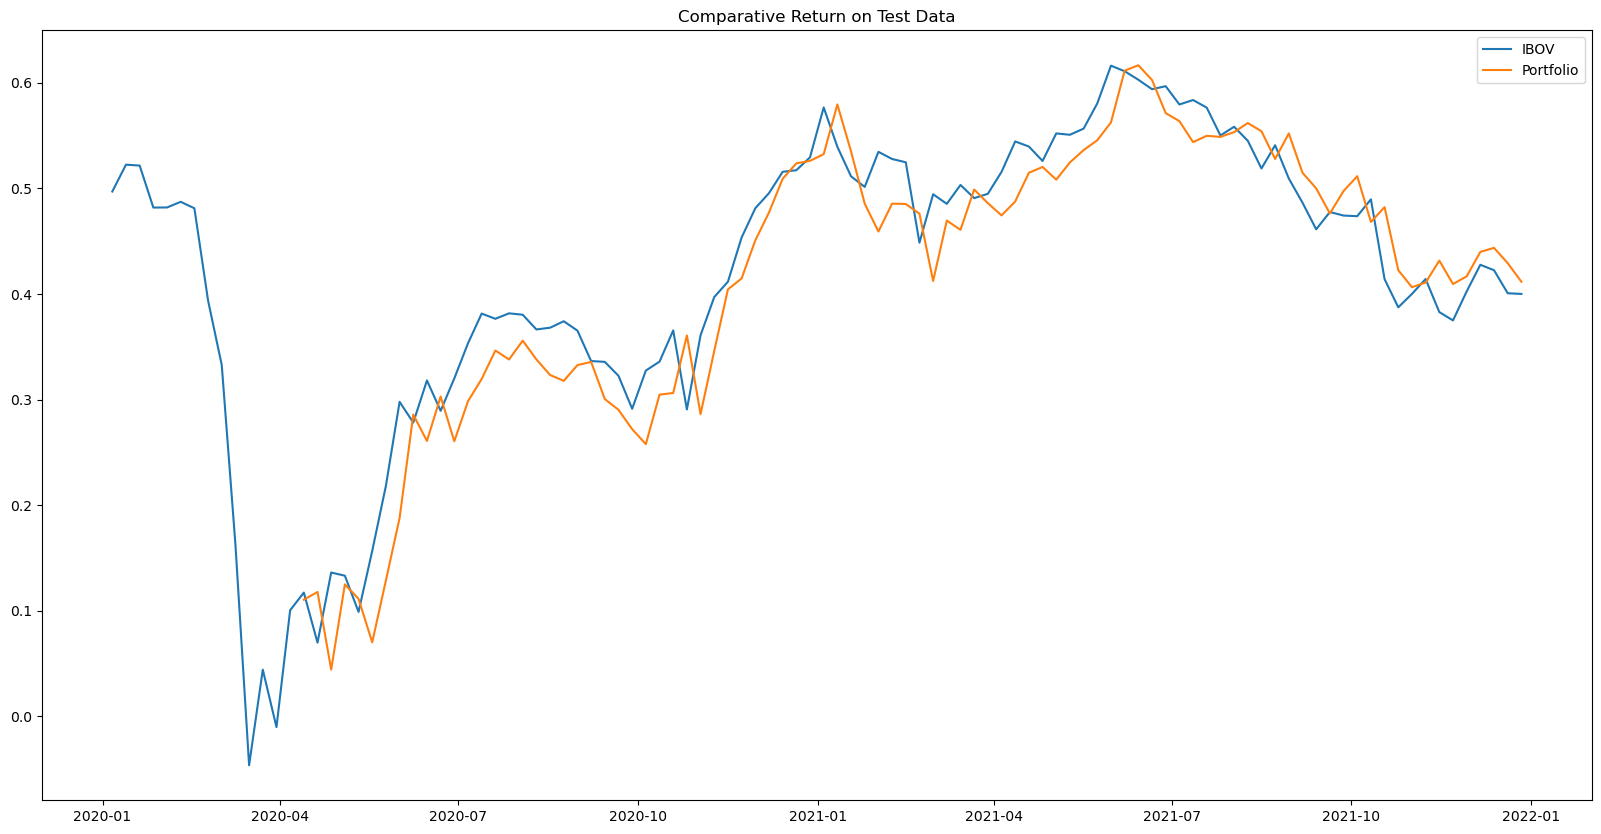

In [25]:
plt.figure(figsize=(20,10))
plt.plot(test_ibov,label="IBOV")
plt.plot(portifolio_cummulative_return,label="Portfolio")
plt.title("Comparative Return on Test Data")
plt.legend()
plt.savefig("../output/images/comparative_return_test_justreturn_ret_"+return_type+".png")
plt.show()